In [55]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithm
from xgboost import XGBRegressor

# sklearn for data partitioning
import sklearn
from sklearn.model_selection import train_test_split

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [56]:
#Import data as dataframe
df = pd.read_csv('Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   date_time       48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [58]:
df['holiday'].value_counts(dropna = False)

holiday
NaN                          48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

In [59]:
# Replacing NaN values with None
df['holiday'] = df['holiday'].replace(to_replace=np.NaN, value=None)
df['holiday'].value_counts(dropna = False)

holiday
None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

In [60]:
#using pd.to_datetime to convert date_time column into proper data type
df['date_time'] = pd.to_datetime(df['date_time'])

#creating year, month, day of week, and hour columns using dt functions
df['month'] = df['date_time'].dt.month_name()
df['weekday'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume,month,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545,October,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516,October,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767,October,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026,October,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918,October,Tuesday,13


In [ ]:
# Dropping date_time and year columns
df = df.drop('date_time', axis=1)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,5545,October,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,4516,October,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,4767,October,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,5026,October,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,4918,October,Tuesday,13


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
 7   month           48204 non-null  object 
 8   weekday         48204 non-null  object 
 9   hour            48204 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 3.5+ MB


In [64]:
# converting hour column to object type
df['hour'] = df['hour'].astype('object')

In [67]:
# Input and Output Features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']

In [71]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [124]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [125]:
# Define Model
reg = XGBRegressor(random_state=42)

# Fit the model
start = time.time()            # Start Time
reg.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.5405521392822266s


In [126]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 444.54


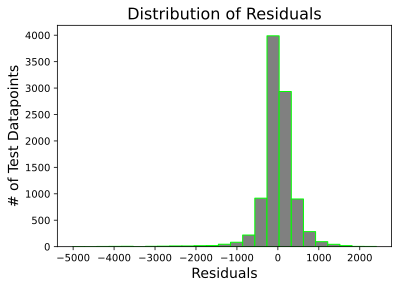

In [128]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'grey', edgecolor = 'lime')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

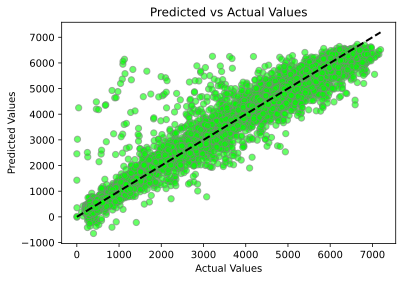

In [132]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'lime', alpha = 0.6, edgecolor = 'grey', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'black', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

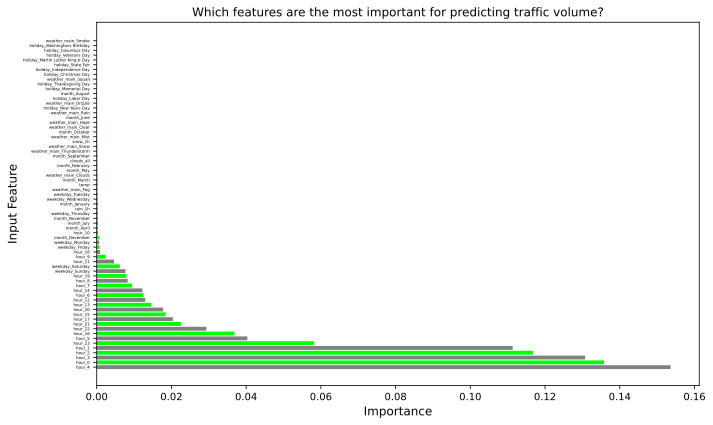

In [127]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['grey', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 4) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

In [133]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 12.07650351524353s


In [134]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

In [135]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.76%


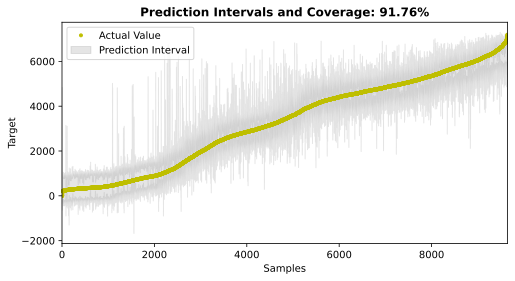

In [141]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'yo', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="grey", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

In [142]:
# Creating the file where we want to write the model
reg_pickle = open('reg_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()

TESTING BEFORE IMPLEMENTING TO STREAMLIT

In [149]:
prediction, intervals = mapie.predict(train_X.head(1), alpha=.1)

In [151]:
prediction[0]

1975.8314

In [156]:
intervals[:, 1][0][0]

2731.193115234375

In [ ]:
default_df = X

In [165]:
X

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,month,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,October,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,October,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,October,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,October,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,October,Tuesday,13
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,September,Sunday,19
48200,None,282.76,0.0,0.0,90,Clouds,September,Sunday,20
48201,None,282.73,0.0,0.0,90,Thunderstorm,September,Sunday,21
48202,None,282.09,0.0,0.0,90,Clouds,September,Sunday,22


In [174]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   holiday       61 non-null     object 
 1   temp          48204 non-null  float64
 2   rain_1h       48204 non-null  float64
 3   snow_1h       48204 non-null  float64
 4   clouds_all    48204 non-null  int64  
 5   weather_main  48204 non-null  object 
 6   month         48204 non-null  object 
 7   weekday       48204 non-null  object 
 8   hour          48204 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 3.3+ MB


In [170]:
user_df = pd.read_csv('traffic_data_user.csv')
user_df['holiday'].value_counts(dropna=False)

holiday
NaN    5
Name: count, dtype: int64

In [172]:
user_df = pd.read_csv('traffic_data_user.csv')
user_df['hour'] = user_df['hour'].astype('object')
user_df['holiday'] = user_df['holiday'].replace(to_replace=np.NaN, value=None)

attached_df = pd.concat([X, user_df])

#get dummies and extract just the user data
big_encode_dummy_df = pd.get_dummies(attached_df)
big_user_encoded_df = big_encode_dummy_df.tail(len(user_df))

#make predictions on user data
prediction, intervals = mapie.predict(big_user_encoded_df, alpha = .2)

#append results to original dataframe
user_df['Prediction'] = prediction
user_df['Lower CI Limit'] = intervals[:, 0]
user_df['Lower CI Limit'] = user_df['Lower CI Limit'].apply(lambda x: max(0, x))
user_df['Upper CI Limit'] = intervals[:, 1]

user_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,month,weekday,hour,Prediction,Lower CI Limit,Upper CI Limit
0,None,289.49,0.0,0.0,1,Fog,July,Friday,7,5815.619629,5313.853027,6196.562256
1,None,279.35,0.0,0.0,1,Clear,October,Monday,21,2315.078369,1863.752441,2660.645752
2,None,291.39,0.0,0.0,36,Clouds,June,Wednesday,0,734.855042,316.982239,1110.154602
3,None,294.02,0.0,0.0,90,Thunderstorm,July,Wednesday,22,2050.493652,1564.685913,2442.782471
4,None,268.69,0.0,0.0,64,Mist,December,Friday,9,4652.031738,4328.593262,5154.515869


In [189]:
X.to_csv('example_data.csv', index=False)